<a href="https://colab.research.google.com/github/Fjoru/TM10007_PROJECT/blob/Jessica/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Prediction of tumor grade in brain cancer
By Jessica Barends, Gonnie van Erp, Erik Kemper en Carlijn Oerlemans

In [2]:
# Run install for use in colab environment
!pip install --upgrade pip
!pip install -q --upgrade git+https://github.com/Fjoru/TM10007_PROJECT
!pip install ipdb -q
!pip install seaborn
!pip install tensorflow

     |████████████████████████████████| 1.4MB 8.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


## Import section


In [3]:
import ipdb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

# Classifiers
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
#from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn import model_selection
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## preprocessing

In [0]:
def Replace(i):
    if isinstance(i, int):
          return i
    try:
        float(i)
        return float(i)
    except:
        return np.nan

def preprocessing_steps(X_design, Y_design, X_test, Y_test):
    # training set
    # remove strings from data
    X_design = X_design.applymap(func=Replace)

    # set 0.0 as NaN
    X_design.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_design.replace([np.inf, -np.inf], np.nan, inplace=True)

    # remove features with less than 60% values
    X_design = X_design.dropna(thresh=round(X_design.shape[0]*0.6), axis='columns')

    # remove sample with less than 60% values
    # join features and labels
    XY_design = X_design.join(Y_design)
    # remove samples with not enough values
    XY_design = XY_design.dropna(thresh=round(XY_design.shape[1]*0.6))

    # remove samples without a label
    XY_design['label'].replace(np.nan, '', inplace=True)
    XY_design = XY_design[XY_design['label'].astype(bool)]

    # split features (X_data) and labels (Y_data)
    X_design = XY_design.drop(columns=['label'])
    Y_design = XY_design[['label']]
    
    # add missing value's 
    imputer = IterativeImputer(sample_posterior=True, n_nearest_features=20, random_state=0)
    X_design_imputed = imputer.fit_transform(X_design)

    # normalization of values
    scaler = RobustScaler()
    X_design_scaled = scaler.fit_transform(X_design_imputed)

    # getting back to Dataframe 
    X_design = pd.DataFrame(X_design_scaled, columns=X_design.columns, index=X_design.index)

    #X_data = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(X_data), columns=X_data.index, index=X_data.columns)
    #X_data = pd.DataFrame(QuantileTransformer(output_distribution='uniform').fit_transform(X_data), columns=X_data.columns, index=X_data.index) # output_distribution='normal'

    # test set
    # remove strings from data
    X_test = X_test.applymap(func=Replace)

    # set 0.0 as NaN
    X_test.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # remove the same features as the design set
    features_design = X_design.columns
    features_design = X_design.columns
    
    df_test = None
    for feature in features_design:
      df_test_single = pd.DataFrame(X_test[feature])
      if df_test is None:
        df_test = df_test_single
      else:
        df_test = df_test.join(df_test_single, how='outer')
    
    X_test = df_test
    
    # remove sample with less than 60% values
    # join features and labels
    XY_test = X_test.join(Y_test)
    # remove samples with not enough values
    XY_test = XY_test.dropna(thresh=round(XY_test.shape[1]*0.6))

    # remove samples without a label
    XY_test['label'].replace(np.nan, '', inplace=True)
    XY_test = XY_test[XY_test['label'].astype(bool)]

    # split features (X_test) and labels (Y_test)
    X_test = XY_test.drop(columns=['label'])
    Y_test = XY_test[['label']]
    
    # add missing value's 
    X_test_imputed = imputer.transform(X_test)

    # normalization of values
    X_test_scaled = scaler.transform(X_test_imputed)

    # getting back to Dataframe 
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_design, Y_design, X_test, Y_test

## Feature selection and extraction

In [0]:
def feature_steps(X_data, Y_data):

    impo_clf = ExtraTreesClassifier(n_estimators=50)
    impo_clf = impo_clf.fit(X_data, Y_data)
    impo_clf.feature_importances_

    importances = impo_clf.feature_importances_
    std = np.std([impo_clf.feature_importances_ for tree in impo_clf.estimators_], 
                 axis=0)
    indices = np.argsort(importances)[::-1]


    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_data.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_data.shape[1]), indices)
    plt.xlim([-1, X_data.shape[1]])
    plt.show()

    model = SelectFromModel(impo_clf, prefit=True)
    X_data = model.transform(X_data)

    return X_data, Y_data

## Run Pipeline

run all predefined steps

The number of samples: 167
The number of columns: 725
              VOLUME_ET  VOLUME_NET  ...  TGM_Cog_Z_1   TGM_T_1
ID                                   ...                       
TCGA-02-0064   0.423858   -0.149335  ...    -0.409811  0.412749
TCGA-02-0068  -0.071461   -0.098523  ...    -0.254765 -0.182429
TCGA-02-0069   0.070091    0.912666  ...     0.284368  2.705034
TCGA-02-0070  -0.232420   -0.314443  ...     0.839935 -0.449039
TCGA-02-0075  -0.046043    0.247846  ...     0.451606 -0.017942
...                 ...         ...  ...          ...       ...
TCGA-HT-8018  -0.495015   -0.179239  ...    -0.849962 -0.833459
TCGA-HT-8111  -0.501256   -0.381408  ...     1.026131 -0.804997
TCGA-HT-8114  -0.241514    3.740634  ...     0.526592 -0.757509
TCGA-HT-8563  -0.127283   -0.367314  ...    -0.466627 -0.801878
TCGA-HT-A61A   0.503820    1.082333  ...    -0.592295  0.330073

[150 rows x 692 columns]
shape of the design set is: (150, 692)
              VOLUME_ET  VOLUME_NET  ...  TGM_Cog

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


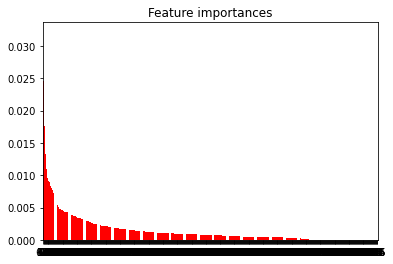

In [11]:
# Data loading functions.
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data = pd.DataFrame(data)

# split labels and values
data_X = data.drop(columns=['label'])
data_Y = data[['label']]

# data split index forming
Test_split = model_selection.StratifiedKFold(n_splits=10)
i = 0
for design_index, test_index in Test_split.split(data_X, data_Y):
    if i:
      continue
    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

    # run preprocessing step
    X_design, Y_design, X_test, Y_test = preprocessing_steps(X_design, Y_design, X_test, Y_test)
    print(X_design)
    print(f'The shape of the design set is: {X_design.shape}')
    print(X_test)
    print(f'The shape of the test set is: {X_test.shape}')

    #run feature selection and extraction
    X_design, Y_design = feature_steps(X_design, Y_design)

    i = 1
   

# save data to csv for manual check
#X_design.to_csv('data_X.csv')
#Y_design.to_csv('data_Y.csv')

